<a href="https://colab.research.google.com/github/hsu607/Data-Mentoring/blob/main/Data_mentoring_Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#matplotlib 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,101 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
#필요한 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import json
from pandas.io.json import json_normalize
import os
import webbrowser
import folium
from folium import plugins
from folium.features import DivIcon
from folium.plugins import HeatMap
import sys
sys.path.append('/content/drive/MyDrive/거북R/데멘토/Data/')
import config
from config import vworld_key
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.io as po
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

#경고 무시
import warnings
warnings.filterwarnings('ignore')

#matplotlib 한글 깨짐 방지
plt.rc('font', family='NanumBarunGothic') 

# Ⅰ. 서론

## 1. 제안배경 및 필요성

### [OECD 국가 별 교통사고]

In [ ]:
oecd1 = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/세계 보행자 사고 건수_인구.csv')
oecd2 = pd.read_excel('/content/drive/MyDrive/거북R/데멘토/Data/oecd.xlsx')

In [ ]:
oecd1.rename(columns={'Country':'국가'},inplace=True)
oecd1['사고건수'] = 0.0
oecd1['사고건수'] = (oecd1['Accident'] / oecd1['Population']) * 100000
oecd1 = oecd1.sort_values(by='사고건수',ascending=False)

oecd2 = oecd2.sort_values(by='사망자수 평균',ascending=False)

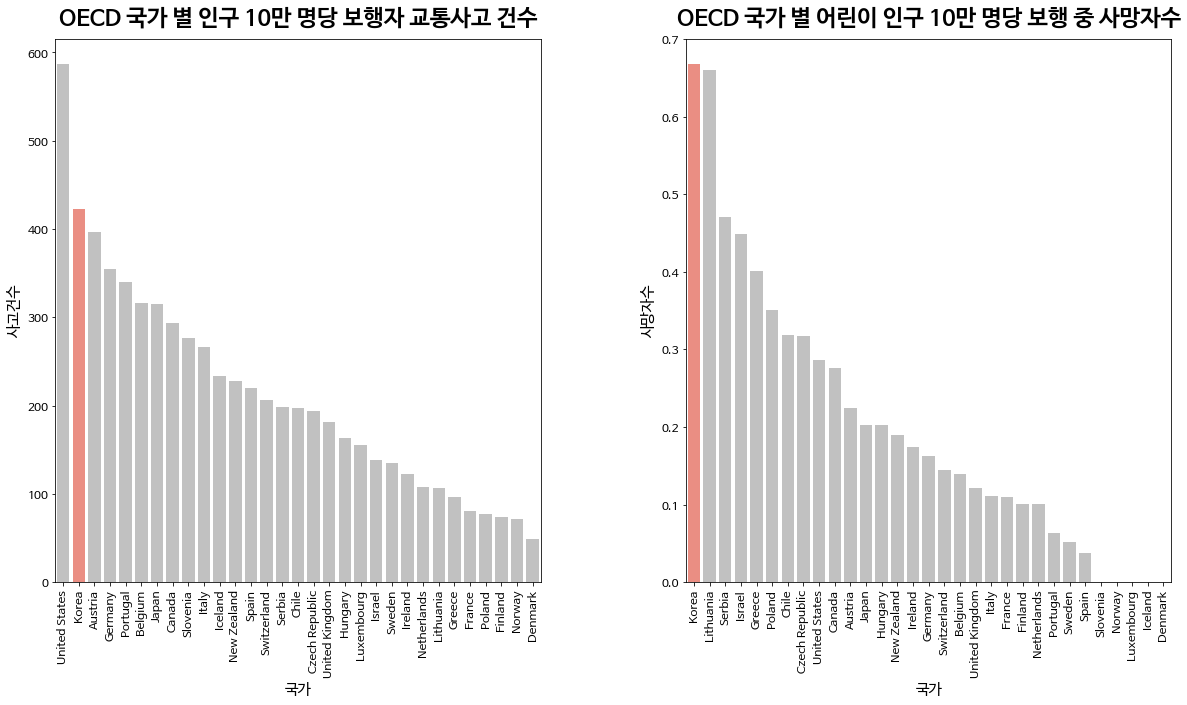

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.subplots_adjust(wspace=0.3,hspace=0.5)

colors1 = list(np.repeat("#c1c1c1",1)) + list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",29))
colors2 = list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",30))

plt.subplot(121)
sns.barplot(x='국가', y='사고건수', data=oecd1, palette=colors1)
plt.title('OECD 국가 별 인구 10만 명당 보행자 교통사고 건수', fontsize=23, weight='bold', pad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('국가',fontsize=15)
plt.ylabel('사고건수',fontsize=15)

plt.subplot(122)
sns.barplot(x='국가',y='사망자수 평균',data=oecd2, palette=colors2)
plt.title('OECD 국가 별 어린이 인구 10만 명당 보행 중 사망자수', fontsize=23, weight='bold', pad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('국가',fontsize=15)
plt.ylabel('사망자수',fontsize=15)

plt.show()

### [연도별 어린이 교통사고]

In [ ]:
#어린이 보행자 교통사고
child = pd.DataFrame({
    'year':['2017','2018','2019','2020','2021'],
    'count':[4019, 3582, 3856, 2079, 2451]})

#스쿨존 내 어린이 교통사고
school = pd.DataFrame({
    'year':['2017','2018','2019','2020','2021'],
    'count':[464, 418, 532, 464,	501]})
school['rate'] = school['count']/child['count'] * 100

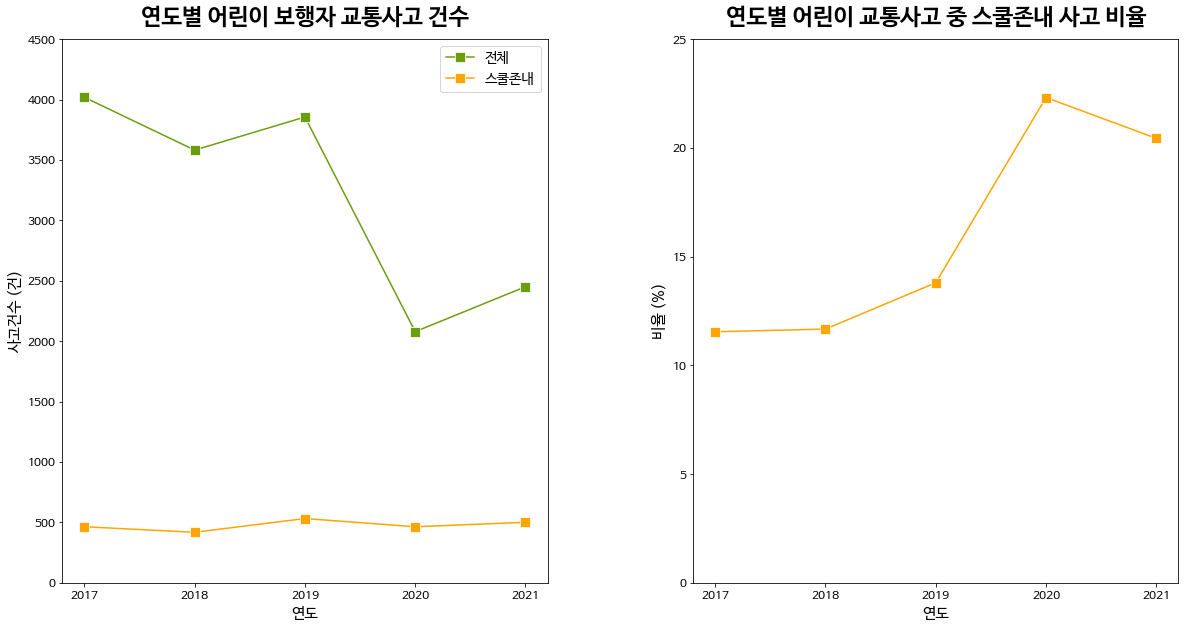

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.3,hspace=0.5)

plt.subplot(121)
sns.lineplot(x='year', y='count', data=child, label="전체",color="#6B9D0E", marker='s',markersize=10)
sns.lineplot(x='year', y='count', data=school, label = "스쿨존내", color="orange", marker='s', markersize=10)
plt.title('연도별 어린이 보행자 교통사고 건수', fontsize=23, weight='bold', pad=15)
plt.ylabel('사고건수 (건)', fontsize=15)
plt.ylim(0,4500)
plt.xlabel("연도", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.subplot(122)
sns.lineplot(x='year',y='rate',data=school, color="orange", marker='s', markersize=10)
plt.title('연도별 어린이 교통사고 중 스쿨존내 사고 비율', fontsize=23, weight='bold', pad=15)
plt.ylabel('비율 (%)', fontsize=15)
plt.ylim(0,25)
plt.xlabel("연도", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Ⅱ. EDA

## 1. 어린이 교통사고 데이터 변수별 특징

### [EDA 그래프]

In [ ]:
accident = pd.read_table('/content/drive/MyDrive/거북R/데멘토/Data/accident_total.txt',sep=',')

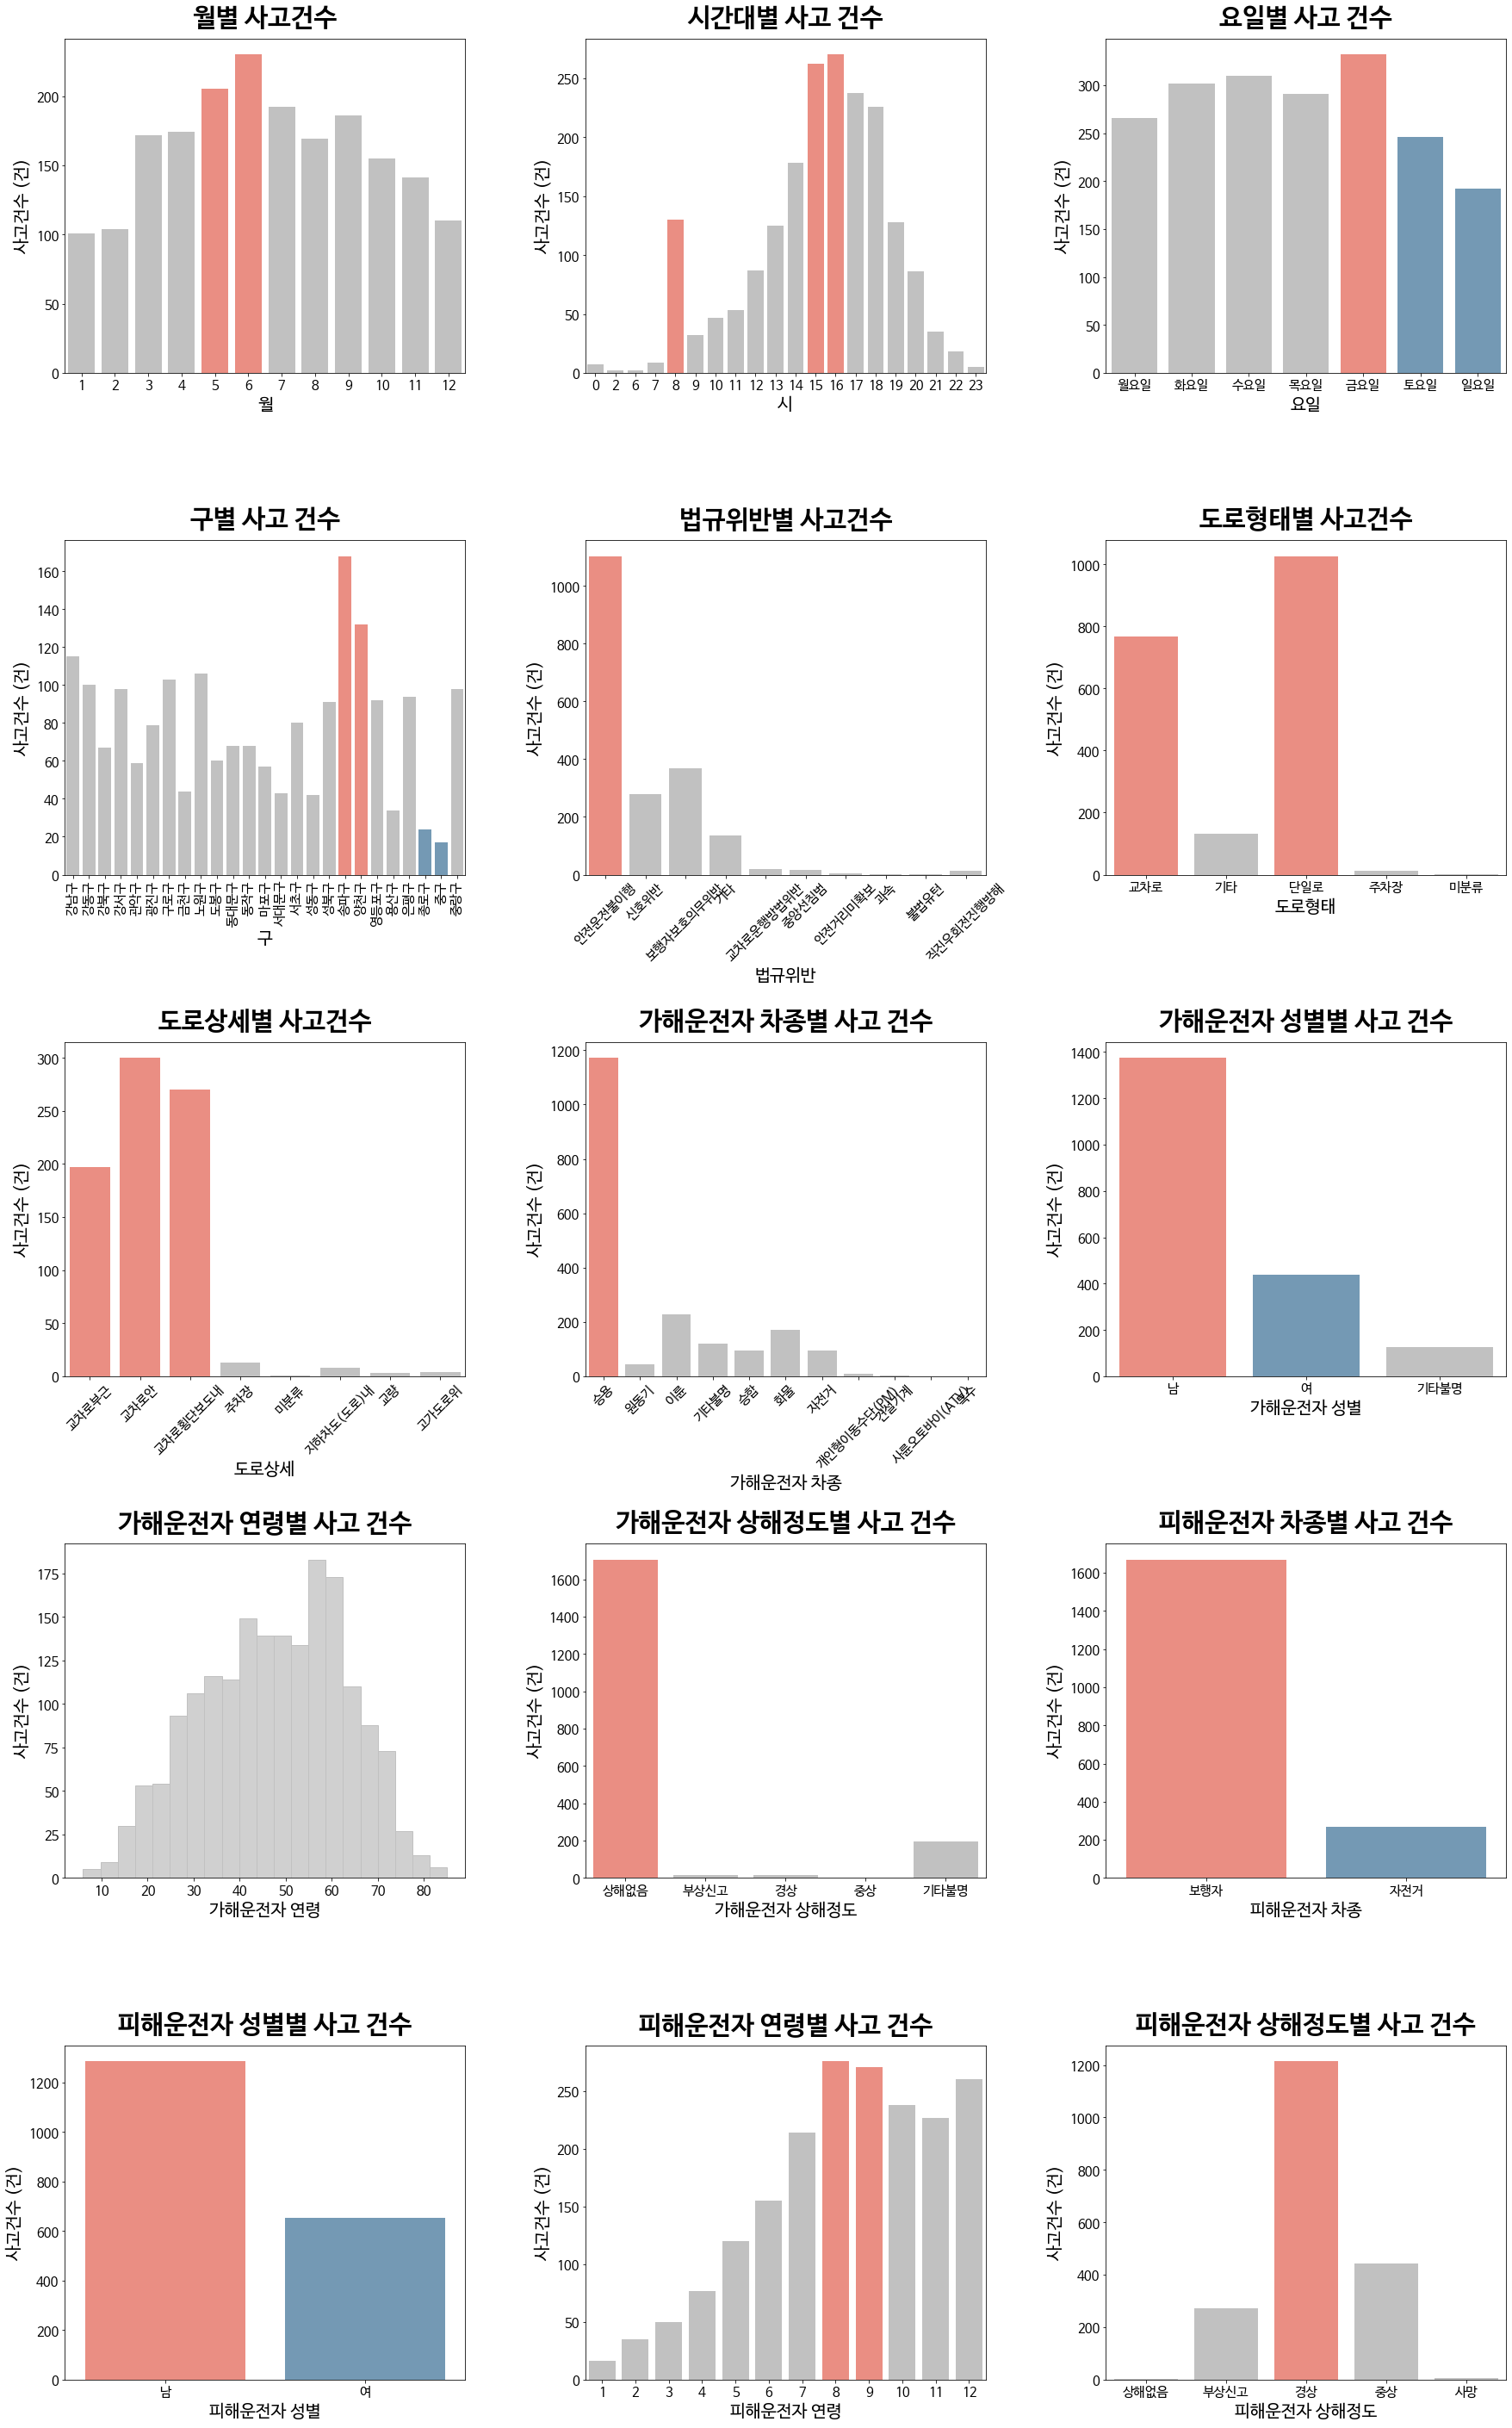

In [ ]:
fig, axes = plt.subplots(5,3,figsize=(30,50))
fig.subplots_adjust(wspace=0.3,hspace=0.5)

#월별 사고 건수
colors= list(np.repeat("#c1c1c1",4)) + list(np.repeat("#fb8072",2)) +list(np.repeat("#c1c1c1",6))
plt.subplot(531)
sns.countplot(x='월',data=accident, palette=colors)
plt.title('월별 사고건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('월', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#시간대별 사고 건수
colors= list(np.repeat("#c1c1c1",4)) + list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",6))+list(np.repeat("#fb8072",2))+list(np.repeat("#c1c1c1",7))
plt.subplot(532)
sns.countplot(x='시',data=accident, palette=colors)
plt.title('시간대별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('시', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#요일별 사고 건수
colors= list(np.repeat("#c1c1c1",4)) + list(np.repeat("#fb8072",1)) +list(np.repeat("#6a9bbe",2))
plt.subplot(533)
sns.countplot(x='요일',data=accident,order=['월요일','화요일','수요일','목요일','금요일','토요일','일요일'], palette=colors)
plt.title('요일별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('요일', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 구별 사고 건수
gu = list(accident.sort_values(by='구')['구'].unique())
colors= list(np.repeat("#c1c1c1",17)) + list(np.repeat("#fb8072",2)) +list(np.repeat("#c1c1c1",3))+list(np.repeat("#6a9bbe",2))+list(np.repeat("#c1c1c1",1))
plt.subplot(534)
sns.countplot(x='구',data=accident, order=gu, palette=colors)
plt.title('구별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('구', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

#법규위반 유형별 사고건수
colors=list(np.repeat("#fb8072",1))+list(np.repeat("#c1c1c1",9))
plt.subplot(535)
sns.countplot(x='법규위반', data=accident, palette=colors)
plt.title('법규위반별 사고건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('법규위반', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

#도로형태별 사고 건수
colors= list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",1))+list(np.repeat("#fb8072",1))+list(np.repeat("#c1c1c1",2))
plt.subplot(536)
sns.countplot(x='도로형태',data=accident, palette=colors)
plt.title('도로형태별 사고건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('도로형태', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#도로상세별 사고 건수
doro = accident[accident['도로상세']!='기타']
colors= list(np.repeat("#fb8072",3)) +list(np.repeat("#c1c1c1",5))
plt.subplot(537)
sns.countplot(x='도로상세',data=doro, palette=colors)
plt.title('도로상세별 사고건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('도로상세', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

#가해운전자 차종별 사고 건수
colors = list(np.repeat("#fb8072",1)) + list(np.repeat("#c1c1c1",10))
plt.subplot(538)
sns.countplot(x='가해운전자 차종', data=accident, palette=colors)
plt.title('가해운전자 차종별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('가해운전자 차종', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

#가해운전자 성별
plt.subplot(539)
sns.countplot(x='가해운전자 성별',data=accident, order=['남','여','기타불명'], palette=["#fb8072","#6a9bbe", "#c1c1c1"])
plt.title('가해운전자 성별별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('가해운전자 성별', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#가해운전자 연령 분포
age = accident[accident['가해운전자 연령']!=0] # 연령불명 데이터 제거
plt.subplot(5,3,10)
sns.histplot(x='가해운전자 연령', data=age, color="#c1c1c1", edgecolor="#c1c1c1")
plt.title('가해운전자 연령별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('가해운전자 연령', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#가해운전자 상해정도
colors= list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",4))
plt.subplot(5,3,11)
sns.countplot(x='가해운전자 상해정도',data=accident, order=['상해없음','부상신고','경상','중상','기타불명'], palette=colors)
plt.title('가해운전자 상해정도별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('가해운전자 상해정도', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#피해운전자 차종별 사고 건수
plt.subplot(5,3,12)
sns.countplot(x='피해운전자 차종', data=accident, palette=["#fb8072","#6a9bbe"])
plt.title('피해운전자 차종별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('피해운전자 차종', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

#피해운전자 성별
plt.subplot(5,3,13)
sns.countplot(x='피해운전자 성별',data=accident, palette=["#fb8072","#6a9bbe"])
plt.title('피해운전자 성별별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('피해운전자 성별', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#피해운전자 연령 분포
colors= list(np.repeat("#c1c1c1",7)) + list(np.repeat("#fb8072",2)) + list(np.repeat("#c1c1c1",3))
plt.subplot(5,3,14)
sns.countplot(x='피해운전자 연령', data=accident, palette=colors)
plt.title('피해운전자 연령별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('피해운전자 연령', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#피해운전자 상해정도
colors= list(np.repeat("#c1c1c1",2)) + list(np.repeat("#fb8072",1)) + list(np.repeat("#c1c1c1",2))
plt.subplot(5,3,15)
sns.countplot(x='피해운전자 상해정도',data=accident, order=['상해없음','부상신고','경상','중상','사망'], palette=colors)
plt.title('피해운전자 상해정도별 사고 건수', fontsize=30, weight='bold', pad=15)
plt.xlabel('피해운전자 상해정도', fontsize=20)
plt.ylabel('사고건수 (건)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## 2. 어린이 교통사고의 특징

### [전체 사고 vs 어린이 사고 시각화]

In [ ]:
accident_total = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/accident_adult.csv', encoding= 'cp949')

In [ ]:
adult_시간 = pd.DataFrame(accident_total.groupby('시')['일'].count()/len(accident_total)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율')
kid_시간 = pd.DataFrame(accident.groupby('시')['일'].count()/len(accident)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율')

adult_시간['비율'] = adult_시간['비율']*100
kid_시간['비율'] = kid_시간['비율']*100

adult_시간.sort_values(by='시', inplace=True)
adult_시간['시'] = adult_시간['시'].astype('string')

In [ ]:
adult_월 = pd.DataFrame(accident_total.groupby('월')['일'].count()/len(accident_total)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율')
kid_월 = pd.DataFrame(accident.groupby('월')['일'].count()/len(accident)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율')

adult_월['비율'] = adult_월['비율']*100
kid_월['비율'] = kid_월['비율']*100

adult_월.sort_values(by='월', inplace=True)
adult_월['월'] = adult_월['월'].astype('string')

In [ ]:
#구별 전체 사고 건수
tot_df = pd.DataFrame(accident_total['구'].value_counts())
tot_df.reset_index(inplace=True)

#구별 어린이 사고 건수
child_df = pd.DataFrame(accident['구'].value_counts())
child_df.reset_index(inplace=True)

#전체 사고수 대비 어린이 사고수 비율
mer = pd.merge(tot_df, child_df, on='index', how='left')
mer.sort_values(by='index', inplace=True)
mer.rename(columns={'index':'구'})
mer['rate'] = mer['구_y']/mer['구_x'] * 100

In [ ]:
adult_법규 = pd.DataFrame(accident_total.groupby('법규위반')['일'].count()/len(accident_total)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율', ascending=False)
kid_법규 = pd.DataFrame(accident.groupby('법규위반')['일'].count()/len(accident)).reset_index().rename(columns={'일':'비율'}).sort_values(by='비율', ascending=False)

adult_법규['비율'] = adult_법규['비율']*100
kid_법규['비율'] = kid_법규['비율']*100

#어린이 사고 데이터의 법규위반 항목에 차로위반이 추가되어있음
kid_법규.loc[10] = ['차로위반',0.0]

adult_법규.set_index('법규위반', inplace=True)
kid_법규.set_index('법규위반', inplace=True)

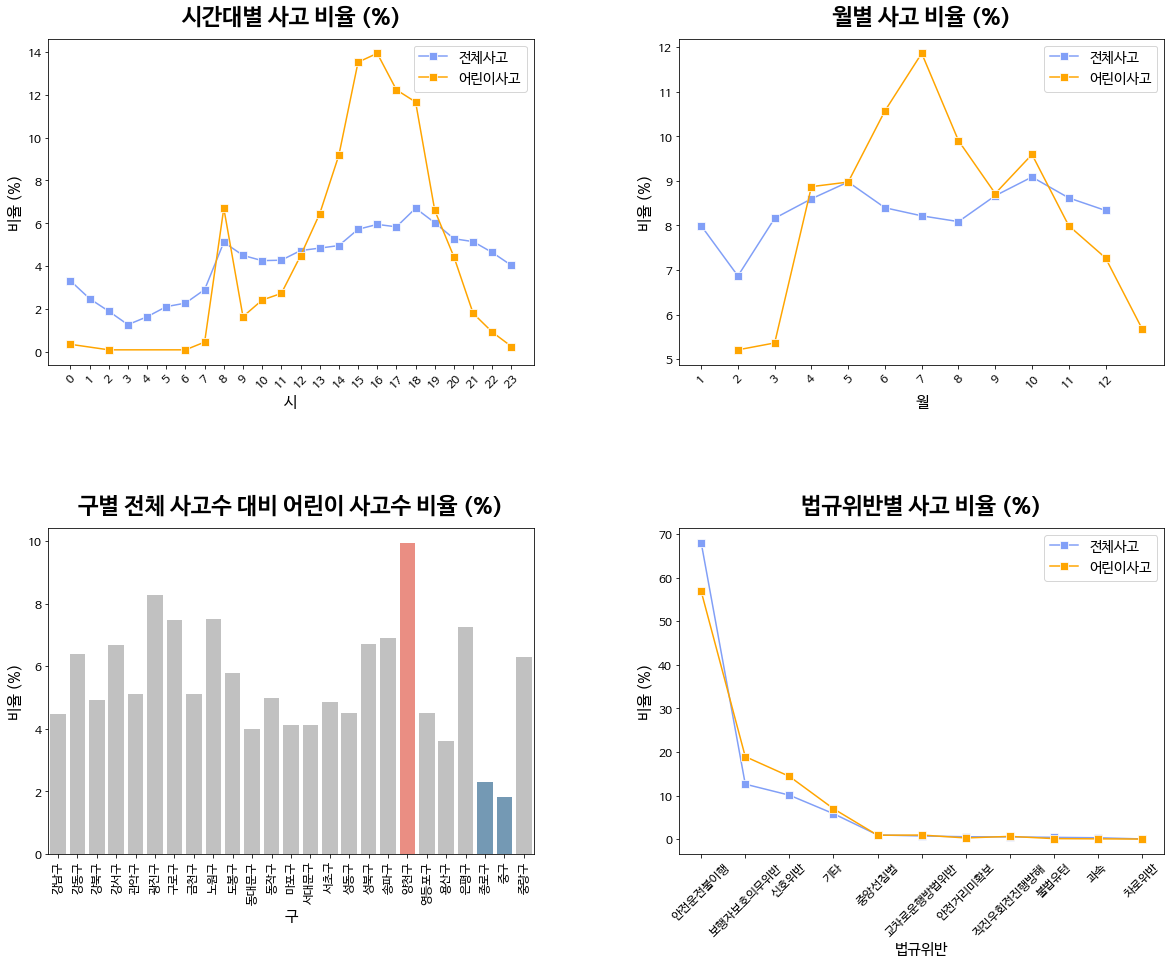

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(20,15))
fig.subplots_adjust(wspace=0.3,hspace=0.5)

#시간대별 사고비율
plt.subplot(221)
sns.lineplot(x='시', y='비율', data=adult_시간, label="전체사고",c="#819FF7", marker='s',markersize=8)
sns.lineplot(x='시', y='비율', data=kid_시간, label="어린이사고",color="orange", marker='s',markersize=8)
plt.title("시간대별 사고 비율 (%)", fontsize=23, weight='bold', pad=15)
plt.xlabel("시", fontsize=15)
plt.ylabel("비율 (%)",fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

#월별 사고비율
plt.subplot(222)
sns.lineplot(x='월',y='비율',data=adult_월, label="전체사고",color="#819FF7", marker='s',markersize=8)
sns.lineplot(x='월',y='비율',data=kid_월 ,label="어린이사고",color="orange", marker='s',markersize=8)
plt.title("월별 사고 비율 (%)", fontsize=23, weight='bold', pad=15)
plt.xlabel("월", fontsize=15)
plt.ylabel("비율 (%)",fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

#구별 전체 사고수 대비 어린이 사고수 비율
colors= list(np.repeat("#c1c1c1",18)) + list(np.repeat("#fb8072",1)) +list(np.repeat("#c1c1c1",3))+list(np.repeat("#6a9bbe",2))+list(np.repeat("#c1c1c1",1))
plt.subplot(223)
sns.barplot(x='index',y='rate',data=mer, palette=colors)
plt.title('구별 전체 사고수 대비 어린이 사고수 비율 (%)', fontsize=23, weight='bold', pad=15)
plt.xlabel("구", fontsize=15)
plt.ylabel("비율 (%)",fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

#법규위반 별 사고비율
plt.subplot(224)
sns.lineplot(x='법규위반',y='비율',data=adult_법규, label="전체사고",color="#819FF7", marker='s',markersize=8)
sns.lineplot(x='법규위반',y='비율',data=kid_법규 ,label="어린이사고",color="orange", marker='s',markersize=8)
plt.title("법규위반별 사고 비율 (%)", fontsize=23, weight='bold', pad=15)
plt.xlabel("법규위반", fontsize=15)
plt.ylabel("비율 (%)",fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

plt.show()

## 2. 구별 시각화

### [서울특별시 구별 총인구수 대비 어린이 교통사고 건수]

In [ ]:
num_people = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/서울특별시 구별 총인구.csv',encoding='cp949')
school_zone = pd.read_table('/content/drive/MyDrive/거북R/데멘토/Data/서울특별시 구별 어린이보호구역 위치.txt',sep='\t')

In [ ]:
num_people_data = num_people.loc[1:,'행정구역':'계_총인구수']
num_people_data.reset_index(inplace=True, drop=True)
num_people_data['계_총인구수_순위'] = num_people_data['계_총인구수'].rank(method='dense', ascending=False)
num_people_data = num_people_data.astype({'계_총인구수_순위':'int'})

num_people_data['어린이 교통사고 건수'] = 0
for i in range(len(num_people_data)):
  num_people_data['어린이 교통사고 건수'][i] = accident['사고번호'][accident['구']==num_people_data['행정구역'][i]].count()

num_people_data['어린이 교통사고 건수_순위'] = num_people_data['어린이 교통사고 건수'].rank(method='dense', ascending=False)
num_people_data = num_people_data.astype({'어린이 교통사고 건수_순위':'int'})

num_people_data['총인구수 대비 어린이 교통사고 비율'] = 0.0
for i in range(len(num_people_data)):
  num_people_data['총인구수 대비 어린이 교통사고 비율'][i] = float(num_people_data['어린이 교통사고 건수'][i] / num_people_data['계_총인구수'][i])

num_people_data['총인구수 대비 어린이 교통사고 비율_순위'] = num_people_data['총인구수 대비 어린이 교통사고 비율'].rank(method='dense', ascending=False)
num_people_data = num_people_data.astype({'총인구수 대비 어린이 교통사고 비율_순위':'int'})

In [ ]:
vworld_key="46DE2FDE-2289-3DAD-8A3C-F06F84FEF256"

seoul_map1 = folium.Map(location=[37.55,126.98], zoom_start=12)

korea = '/content/drive/MyDrive/거북R/데멘토/Data/korea_map.json'
seoul_map1.choropleth(geo_data=korea,fill_color='grey',fill_opacity=0.5,line_color='grey',line_opacity=0.1)

state_geo = '/content/drive/MyDrive/거북R/데멘토/Data/seoul_map.json'

layer = "Base"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(seoul_map1)

seoul_map1.choropleth(geo_data=state_geo,
                  data=num_people_data,
                  columns=['행정구역','총인구수 대비 어린이 교통사고 비율'],
                  fill_color='Reds',
                  key_on='feature.properties.SIG_KOR_NM',
                  line_color='dimgrey',
                  line_weight=4,
                  fill_opacity=0.8,
                  legend_name='서울특별시 구별 총인구수 대비 어린이 교통사고 건수')

for name, lat, lng, rank, value in zip(num_people_data['행정구역'], num_people_data['위도'], num_people_data['경도'],  num_people_data['총인구수 대비 어린이 교통사고 비율_순위'], num_people_data['총인구수 대비 어린이 교통사고 비율']):
  folium.map.Marker(
      [lat, lng],
      icon = DivIcon(
          icon_size=(0,0),
          icon_anchor=(10,40),
          html='<div style="font-size:13pt; color:white; font-weight:bold; writing-mode: horizontal-tb; position:absolute; text-shadow: -2px 0 dimgrey, 0 2px dimgrey, 2px 0 dimgrey, 0 -2px dimgrey;">%s</div>' % name),
          popup=folium.Popup('<div style="font-size:10pt; font-weight:bold;">%s</div>' %('순위: ' + str(rank) + '위<br/>만명당: ' + str(round(10000*value,4)) + '건'), max_width=200)).add_to(seoul_map1)

seoul_map1

### [서울특별시 구별 어린이 인구수 대비 어린이 교통사고 건수]

In [ ]:
num_child_data = num_people.loc[1:,'행정구역':'계_연령구간인구수']
num_child_data.drop('계_총인구수', axis=1, inplace=True)
num_child_data.reset_index(inplace=True, drop=True)

num_child_data['계_연령구간인구수_순위'] = num_child_data['계_연령구간인구수'].rank(method='dense', ascending=False)
num_child_data = num_child_data.astype({'계_연령구간인구수_순위':'int'})

num_child_data['어린이 교통사고 건수'] = 0
for i in range(len(num_child_data)):
  num_child_data['어린이 교통사고 건수'][i] = accident['사고번호'][accident['구']==num_child_data['행정구역'][i]].count()

num_child_data['어린이 교통사고 건수_순위'] = num_child_data['어린이 교통사고 건수'].rank(method='dense', ascending=False)
num_child_data = num_child_data.astype({'어린이 교통사고 건수_순위':'int'})

num_child_data['어린이 인구수 대비 어린이 교통사고 비율'] = 0.0
for i in range(len(num_child_data)):
  num_child_data['어린이 인구수 대비 어린이 교통사고 비율'][i] = float(num_child_data['어린이 교통사고 건수'][i] / num_child_data['계_연령구간인구수'][i])

num_child_data['어린이 인구수 대비 어린이 교통사고 비율_순위'] = num_child_data['어린이 인구수 대비 어린이 교통사고 비율'].rank(method='dense', ascending=False)
num_child_data = num_child_data.astype({'어린이 인구수 대비 어린이 교통사고 비율_순위':'int'})

In [ ]:
vworld_key="46DE2FDE-2289-3DAD-8A3C-F06F84FEF256"

seoul_map2 = folium.Map(location=[37.55,126.98], zoom_start=12)

korea = '/content/drive/MyDrive/거북R/데멘토/Data/korea_map.json'
seoul_map2.choropleth(geo_data=korea,fill_color='grey',fill_opacity=0.5,line_color='grey',line_opacity=0.1)

state_geo = '/content/drive/MyDrive/거북R/데멘토/Data/seoul_map.json'

layer = "Base"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(seoul_map2)

seoul_map2.choropleth(geo_data=state_geo,
                  data=num_child_data,
                  columns=['행정구역','어린이 인구수 대비 어린이 교통사고 비율'],
                  fill_color='Reds',
                  key_on='feature.properties.SIG_KOR_NM',
                  line_color='dimgrey',
                  line_weight=4,
                  fill_opacity=0.8,
                  legend_name='서울특별시 구별 어린이 인구수 대비 어린이 교통사고 건수')

for name, lat, lng, rank, value in zip(num_child_data['행정구역'], num_child_data['위도'], num_child_data['경도'],  num_child_data['어린이 인구수 대비 어린이 교통사고 비율_순위'], num_child_data['어린이 인구수 대비 어린이 교통사고 비율']):
  folium.map.Marker(
      [lat, lng],
      icon = DivIcon(
          icon_size=(0,0),
          icon_anchor=(10,40),
          html='<div style="font-size:13pt; color:white; font-weight:bold; writing-mode: horizontal-tb; position:absolute; text-shadow: -2px 0 dimgrey, 0 2px dimgrey, 2px 0 dimgrey, 0 -2px dimgrey;">%s</div>' % name),
          popup=folium.Popup('<div style="font-size:10pt; font-weight:bold;">%s</div>' %('순위: ' + str(rank) + '위<br/>만명당: ' + str(round(10000*value,4)) + '건'), max_width=200)).add_to(seoul_map2)

seoul_map2

# Ⅲ. 어린이 보행자 교통사고의 요인 분석

## 1. 사회적 요인

### [사회적 요인 상관관계 분석]

In [ ]:
accident_feature = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/accident_feature.csv', encoding='cp949')

In [ ]:
feature_gu = accident_feature.iloc[1:,:]
feature_gu.reset_index(inplace=True, drop=True)

feature_gu['버스_이용_비율'] = 0.0
feature_gu['지하철_이용_비율'] = 0.0
feature_gu['대중교통_이용_비율'] = 0.0
for i in range(len(feature_gu)):
  feature_gu['버스_이용_비율'] = feature_gu['버스_승객수'] / (feature_gu['총인구수'] * 365)
  feature_gu['지하철_이용_비율'] = feature_gu['지하철_승객수'] / (feature_gu['총인구수'] * 365)
  feature_gu['대중교통_이용_비율'] = feature_gu['대중교통_승객수'] / (feature_gu['총인구수'] * 365)

feature_gu['어린이보호구역_1개당_cctv_개수'] = 0.0
feature_gu['교과학원분야_평균소비인구_비율'] = 0.0
for i in range(len(feature_gu)):
  feature_gu['어린이보호구역_1개당_cctv_개수'] = feature_gu['어린이보호구역_cctv_개수'] / feature_gu['어린이보호구역_개수']
  feature_gu['교과학원분야_평균소비인구_비율'] = feature_gu['교과학원분야_평균소비인구'] / feature_gu['총인구수']

feature_gu['면적당_지역내총생산'] = 0.0
for i in range(len(feature_gu)):
  feature_gu['면적당_지역내총생산'] = feature_gu['지역내총생산'] / feature_gu['면적']

In [ ]:
feature_gu_rank = feature_gu
feature_gu_rank = feature_gu_rank.iloc[:,0:4]

for i in range(len(feature_gu_rank)):
  for j in range(4,23):
    col_name = feature_gu.columns[j] + '_순위'
    feature_gu_rank[col_name] = feature_gu[feature_gu.columns[j]].rank(method='min', ascending=False)

In [ ]:
feature_gu_rank_new = feature_gu_rank[['행정구역','위도','경도','면적','어린이교통사고_건수_순위','총인구수_순위','어린이인구수_순위','어린이보호구역_개수_순위','어린이보호구역_1개당_cctv_개수_순위','학교수_순위','어린이공원_개수_순위','버스_승객수_순위','지하철_승객수_순위','차량등록대수_순위','면적당_지역내총생산_순위','교과학원분야_평균소비인구_순위']]
feature_gu_rank_new = feature_gu_rank_new.rename(columns={'어린이교통사고_건수_순위':'어린이교통사고_건수','총인구수_순위':'총인구수','어린이인구수_순위':'어린이인구수',
                                                          '어린이보호구역_개수_순위':'어린이보호구역_개수','어린이보호구역_1개당_cctv_개수_순위':'어린이보호구역_1개당_cctv_개수',
                                                          '학교수_순위':'학교수','어린이공원_개수_순위':'어린이공원_개수','버스_승객수_순위':'버스_승객수','지하철_승객수_순위':'지하철_승객수',
                                                          '차량등록대수_순위':'차량등록대수','면적당_지역내총생산_순위':'면적당_지역내총생산','교과학원분야_평균소비인구_순위':'교과학원분야_평균소비인구'})


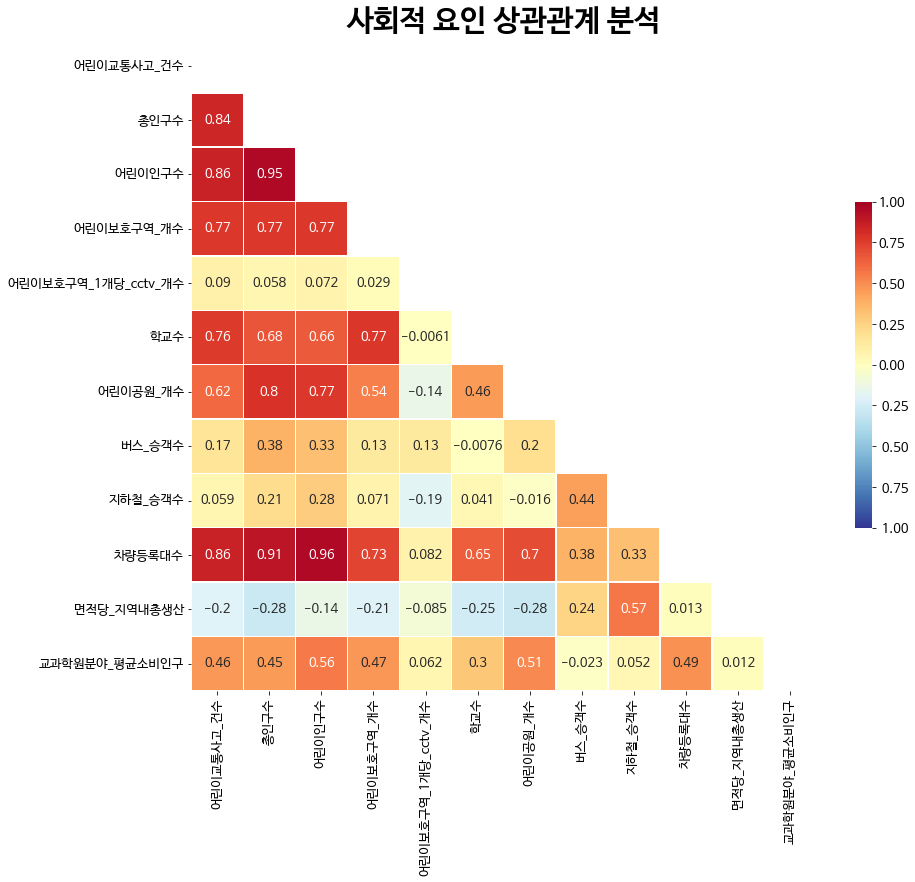

In [ ]:
corr_df = feature_gu_rank_new.iloc[:,4:].corr()

plt.figure(figsize=(14,12))
plt.rc('font', size=13)
plt.title('사회적 요인 상관관계 분석', fontsize=30, weight='bold')

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, 
            cmap = 'RdYlBu_r',
            annot = True,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1)  

plt.show()

In [ ]:
feature_gu_rank_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   행정구역                 25 non-null     object 
 1   위도                   25 non-null     float64
 2   경도                   25 non-null     float64
 3   면적                   25 non-null     float64
 4   어린이교통사고_건수           25 non-null     float64
 5   총인구수                 25 non-null     float64
 6   어린이인구수               25 non-null     float64
 7   어린이보호구역_개수           25 non-null     float64
 8   어린이보호구역_1개당_cctv_개수  25 non-null     float64
 9   학교수                  25 non-null     float64
 10  어린이공원_개수             25 non-null     float64
 11  버스_승객수               25 non-null     float64
 12  지하철_승객수              25 non-null     float64
 13  차량등록대수               25 non-null     float64
 14  면적당_지역내총생산           25 non-null     float64
 15  교과학원분야_평균소비인구        25 non-null     float

In [ ]:
feature_gu_rank_new.iloc[:,[4,5,6,10]].corr()

,어린이교통사고_건수,총인구수,어린이인구수,어린이공원_개수
어린이교통사고_건수,1.000000,0.842847,0.858952,0.615340
총인구수,0.842847,1.000000,0.953846,0.796497
어린이인구수,0.858952,0.953846,1.000000,0.766397
어린이공원_개수,0.615340,0.796497,0.766397,1.000000


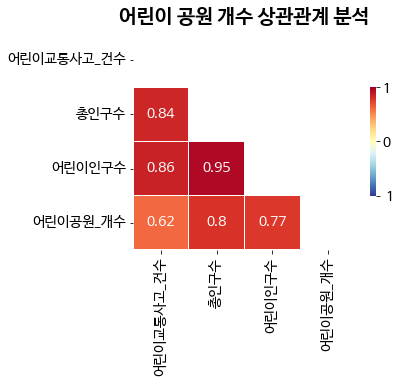

In [ ]:
corr_df = feature_gu_rank_new.iloc[:,[4,5,6,10]].corr()

plt.figure(figsize=(5,4))
plt.rc('font', size=14)
plt.title('어린이 공원 개수 상관관계 분석', fontsize=20, weight='bold', pad=10)

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, 
            cmap = 'RdYlBu_r',
            annot = True,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1)  
plt.yticks(rotation=0)

plt.show()

### [사회적 요인을 반영한 예측 점수]

In [ ]:
feature_score = feature_gu_rank_new.iloc[:,[0,4]]
feature_score = feature_score.astype({'어린이교통사고_건수':'int'})
feature_score = pd.DataFrame(feature_score)

col_list = feature_gu_rank_new.columns
feature_score['Score'] = 0.0
feature_score['Score'] = feature_gu_rank_new[col_list[5]] * 0.84 + feature_gu_rank_new[col_list[7]] * 0.77 + feature_gu_rank_new[col_list[8]] * 0.09 + feature_gu_rank_new[col_list[9]] * 0.76 + feature_gu_rank_new[col_list[10]] * 0.62 + feature_gu_rank_new[col_list[11]] * 0.17 + feature_gu_rank_new[col_list[12]] * 0.059 + feature_gu_rank_new[col_list[13]] * 0.86 - feature_gu_rank_new[col_list[14]] * 0.2 + feature_gu_rank_new[col_list[15]] * 0.46

feature_score['점수'] = 0
feature_score['점수'] = feature_score['Score'].rank(method='min', ascending=True)
feature_score = feature_score.astype({'점수':'int'})

feature_score.sort_values(by='어린이교통사고_건수', ascending=True, inplace=True)

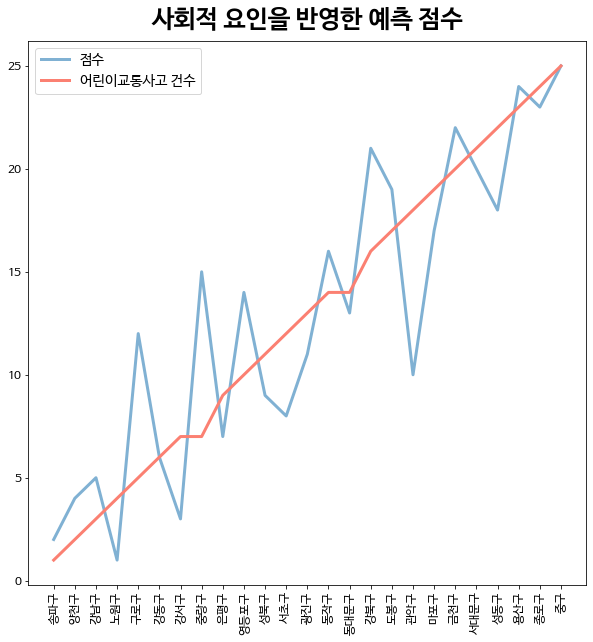

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(feature_score['행정구역'], feature_score['점수'], label = '점수', color = '#80b1d3', linewidth=3)
plt.plot(feature_score['행정구역'], feature_score['어린이교통사고_건수'],  label = '어린이교통사고 건수', color = '#fb8072', linewidth=3)
plt.legend(loc = 0) 
plt.title('사회적 요인을 반영한 예측 점수', fontsize=25, weight='bold', pad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 2. 환경적 요인

### [사고다발지점 히트맵]

In [ ]:
accident = pd.read_table('/content/drive/MyDrive/거북R/데멘토/Data/accident_total.txt',sep=',')

In [ ]:
accident['어린이 보호구역'] = accident['어린이 보호구역'].map({0:'#58ACFA', 1:'#FA5882'})
heat_data = pd.DataFrame(index=range(0,len(accident)), columns={'위도','경도'})
heat_data = accident[['위도','경도']]

In [ ]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:14px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [ ]:
vworld_key="46DE2FDE-2289-3DAD-8A3C-F06F84FEF256"

accident_map = folium.Map(location=[37.55,126.98], zoom_start=12)

korea = '/content/drive/MyDrive/거북R/데멘토/Data/korea_map.json'
accident_map.choropleth(geo_data=korea,fill_color='grey',fill_opacity=0.5,line_color='white',line_opacity=0.1)

state_geo = '/content/drive/MyDrive/거북R/데멘토/Data/seoul_map.json'
accident_map.choropleth(geo_data=state_geo,line_color='grey',line_weight=8,fill_color='white',fill_opacity=0.1,Highlight = True, show = False,overlay = True)

layer = "Base"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(accident_map)

for lat, lng, size, color, date, bicycle, num in zip(accident.위도, accident.경도, accident['사고내용'], accident['어린이 보호구역'], accident['사고일시'], accident['피해운전자 차종'], accident['사고번호']):
    folium.Circle([lat,lng], radius=10, color=color, fill=True, fill_color=color, fill_opacity=1, 
                        popup=folium.Popup('<div style="font-size:10pt; font-weight:bold;">%s</div>' %('사고일시: '+str(date)+'<br>사고번호: '+str(num)+'<br>위도: '+str(lat)+'<br>경도: '+str(lng)), max_width=250)).add_to(accident_map)

HeatMap(heat_data).add_to(accident_map)

add_categorical_legend(accident_map, '어린이 보호구역 여부', colors=['#FA5882','#58ACFA'],
                       labels = ['O','X'])

accident_map

# Ⅳ. 어린이 보호구역 분석

## 1. 초등학교 기준 사고다발지점 지도 시각화

### [초등학교 반경 200m 이내 어린이 교통사고]

In [ ]:
school_elementary = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/school_elementary.csv')
accident_feature = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/accident_feature.csv', encoding='cp949')
roadview = pd.read_excel('/content/drive/MyDrive/거북R/데멘토/Data/로드뷰/로드뷰 사고이전.xlsx', sheet_name='시트1')

In [ ]:
school_elementary['색상'] = school_elementary['반경_200m_이내_사고건수'].map({0:'#8BC34A', 1:'#FCC0BA', 2:'#FF9D96', 3:'#FF7267', 4:'#E62C22',5:'#BF0A00', 6:'#BF0A00'})
accident_feature = accident_feature.iloc[1:,:]
roadview = roadview.astype({'사고번호':'int'})

accident['사고다발지역'] = '#3288bd'
for i in range(len(accident)):
  if accident.iloc[i,0] in list(roadview['사고번호']):
    accident['사고다발지역'][i] = '#6541AF'

In [ ]:
vworld_key="46DE2FDE-2289-3DAD-8A3C-F06F84FEF256"

elementary_map = folium.Map(location=[37.55,126.98], zoom_start=12) 

korea = '/content/drive/MyDrive/거북R/데멘토/Data/korea_map.json'
elementary_map.choropleth(geo_data=korea,fill_color='grey',fill_opacity=0.5,line_color='grey',line_opacity=0.1)

state_geo = '/content/drive/MyDrive/거북R/데멘토/Data/seoul_map.json'
elementary_map.choropleth(geo_data=state_geo,line_color='grey',line_weight=8,fill_color='grey',fill_opacity=0.1,Highlight = True, show = False,overlay = True)

#배경지도 타일 설정하기
layer = "gray"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(elementary_map)

for lat, lng, name, color, num, year in zip(school_elementary.위도, school_elementary.경도, school_elementary.이름, school_elementary.색상, school_elementary.반경_200m_이내_사고건수, school_elementary.최다_사고발생_연도):
    folium.Circle([lat,lng], radius=200, color=color, fill=True, fill_color=color, fill_opacity=0.9, 
                  popup=folium.Popup('<div style="font-size:10pt; font-weight:bold;">%s</div>' %('학교이름: '+str(name) +'<br>반경 200m 이내의 사고 건수: '+str(num)+'건<br>최다 사고발생 연도: '+str(year)+'년'), max_width=250)).add_to(elementary_map)

for lat, lng, num, color in zip(accident.위도, accident.경도, accident.사고번호, accident.사고다발지역): 
    folium.Circle([lat,lng], radius=5, color=color, fill=True, fill_color=color, fill_opacity=1, 
                  popup=folium.Popup('<div style="font-size:10pt; font-weight:bold;">%s</div>' %('사고번호: '+str(num)), max_width=200)).add_to(elementary_map)

for name, lat, lng in zip(accident_feature['행정구역'], accident_feature['위도'], accident_feature['경도']):
  folium.map.Marker(
      [lat, lng],
      icon = DivIcon(
          icon_size=(0,0),
          icon_anchor=(10,40),
          html='<div style="font-size:15pt; color:#383b40; font-weight:bold; writing-mode: horizontal-tb; position:absolute; text-shadow: -2px 0 #ddd, 0 2px #ddd, 2px 0 #ddd, 0 -2px #ddd;">%s</div>' % name)).add_to(elementary_map)

add_categorical_legend(elementary_map, '반경 200m 이내 사고건수', colors=['#8BC34A','#FCC0BA','#FF9D96','#FF7267','#E62C22','#BF0A00'],
                       labels = ['0건','1건','2건','3건','4건','5건 이상'])

add_categorical_legend(elementary_map, '사고다발지역 여부', colors=['#3288bd','#6541AF'],
                       labels = ['O','X'])

elementary_map

## 2. 거리뷰 분석 결과

### [학교 비교 방사형 그래프]

In [ ]:
red = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/빨간색.csv',encoding='cp949')
green = pd.read_csv('/content/drive/MyDrive/거북R/데멘토/Data/초록색.csv',encoding='cp949')

In [ ]:
red['사고구분'] = 1
green['사고구분'] = 0

In [ ]:
grade = pd.DataFrame(columns=(['표지판','보도','과속방지턱','언덕형_과속방지턱','방호울타리','암적색도로',
               '실시간속도측정기','주정차_단속카메라','주정차_차량X','인근횡단보도_신호등','자전거전용도로','지그재그노면표시','신호과속단속장비']))
grade.loc[0] = 0.0
grade.loc[1] = 0.0

col_list = ['표지판', '보도', '과속방지턱', '언덕형_과속방지턱', '실시간속도측정기',
       '주정차_단속카메라', '인근횡단보도_신호등', '자전거전용도로', '지그재그노면표시', '신호과속단속장비']   
for i in col_list:
  grade[i][1] = float(len(red[red[i]=='O']) / len(red[i])) * 100
  grade[i][0] = float(len(green[green[i]=='O']) / len(green[i])) * 100

grade['주정차_차량X'][1] = float(len(red[red['주정차_차량']=='X']) / len(red['주정차_차량'])) * 100
grade['주정차_차량X'][0] = float(len(green[green['주정차_차량']=='X']) / len(green['주정차_차량'])) * 100

col_list = ['방호울타리', '암적색도로']
for i in col_list:
  grade[i][1] = float(np.mean(red[i]) / 100) * 100
  grade[i][0] = float(np.mean(green[i]) / 100) * 100

In [ ]:
red_grade = grade.iloc[1,:]
green_grade = grade.iloc[0,:]

red_grade = [*red_grade, red_grade[0]]
green_grade = [*green_grade, green_grade[0]]

In [ ]:
grade.rename(columns={'언덕형_과속방지턱':'언덕형 과속방지턱', '실시간속도측정기':'실시간 속도측정기', '주정차_단속카메라':'주정차 단속카메라',
                      '주정차_차량X':'주정차 차량 X','인근횡단보도_신호등':'인근 횡단보도 신호등'}, inplace=True)

categories = ['표지판','보도','과속방지턱','언덕형 과속방지턱','방호울타리','암적색도로',
               '실시간 속도측정기','주정차 단속카메라','주정차 차량 X','인근 횡단보도 신호등','자전거전용도로','지그재그노면표시','신호과속단속장비']
categories = [*categories, categories[0]]

In [ ]:
fig = go.Figure(
    data=[
        go.Scatterpolar(r=green_grade, theta=categories, fill='toself', name='사고가 0건인 초등학교', line=dict(color='#66bd63'), textfont=dict(size=15),
                        hovertemplate="비율: %{r}% <extra></extra>"),
        go.Scatterpolar(r=red_grade, theta=categories, fill='toself', name='사고가 4건 이상인 초등학교', line=dict(color='#ef3b2c'), textfont=dict(size=15), 
                        hovertemplate="비율: %{r}% <extra></extra>")],
    layout = go.Layout(
        title=go.layout.Title(text='<b>학교 비교</b>', font=dict(size=30)),
        polar=dict(radialaxis=dict(visible=True)),
        showlegend=True))

iplot(fig)

### [Prop Z-test, Welch's T-test]

In [ ]:
df = pd.concat([red,green])
df.reset_index(drop=True,inplace=True)

1. 표지판

In [ ]:
#교차분석표
crosstab1 = pd.crosstab(df['사고구분'],df['표지판'],margins=False)
crosstab1

표지판,O,X
사고구분,,
0,16,0
1,15,1


In [ ]:
#Prop Z-test
count = np.array([crosstab1.iloc[0,0],crosstab1.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.155


유의수준 = 0.05일 경우 0.155 > 0.05로 귀무가설을 기각하지 못한다. <br>
표지판 유무와 사고 발생은 상관관계가 없다.

----------
2. 과속방지턱

In [ ]:
#교차분석표
crosstab2 = pd.crosstab(df['사고구분'],df['과속방지턱'],margins=False)
crosstab2

과속방지턱,O,X
사고구분,,
0,15,1
1,15,1


In [ ]:
#Prop Z-test
count = np.array([crosstab2.iloc[0,0],crosstab2.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.500


유의수준 = 0.05일 경우 0.500 > 0.05로 귀무가설을 기각하지 못한다. <br>
과속방지턱 유무와 사고 발생은 상관관계가 없다.

--------
3. 언덕형 과속방지턱

In [ ]:
#교차분석표
crosstab3 = pd.crosstab(df['사고구분'],df['언덕형_과속방지턱'],margins=False)
crosstab3

언덕형_과속방지턱,O,X
사고구분,,
0,14,2
1,8,8


In [ ]:
#Prop Z-test
count = np.array([crosstab3.iloc[0,0],crosstab3.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.011


유의수준 = 0.05일 경우 0.011 < 0.05로 귀무가설을 기각한다. <br>
언덕형 과속방지턱 유무와 사고 발생은 상관관계가 있다.

-------
4. 인근 횡단보도 신호등

In [ ]:
#교차분석표
crosstab4 = pd.crosstab(df['사고구분'],df['인근횡단보도_신호등'],margins=False)
crosstab4

인근횡단보도_신호등,O,X
사고구분,,
0,7,9
1,6,10


In [ ]:
#Prop Z-test
count = np.array([crosstab4.iloc[0,0],crosstab4.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.359


유의수준 = 0.05일 경우 0.359 > 0.05로 귀무가설을 기각하지 못한다. <br>
인근 횡단보도 신호등 유무와 사고 발생은 상관관계가 없다.

--------
5. 방호울타리

In [ ]:
#사고구분별 방호울타리 값을 ndarray로 변환
x1_5 = df['방호울타리'][df['사고구분']==0]
x1_5 = np.array(x1_5.values)
x2_5 = df['방호울타리'][df['사고구분']==1]
x2_5 = np.array(x2_5.values)

In [ ]:
#Welch's T-test
print(f'검정 통계치 : {np.round(ttest_ind(x1_5, x2_5,equal_var = False,alternative="greater")[0],3)}\np값 : {ttest_ind(x1_5, x2_5, equal_var = False, alternative="greater")[1]}')

검정 통계치 : 2.744
p값 : 0.00524274089254182


유의수준 = 0.05일 경우 0.0052 < 0.05로 귀무가설을 기각한다. <br>
방호울타리 분포 정도와 사고 발생은 상관관계가 있다.


-------
6. 신호과속단속장비

In [ ]:
#교차분석표
crosstab6 = pd.crosstab(df['사고구분'],df['신호과속단속장비'],margins=False)
crosstab6

신호과속단속장비,O,X
사고구분,,
0,0,16
1,1,15


In [ ]:
#Prop Z-test
count = np.array([crosstab6.iloc[0,0],crosstab6.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.845


유의수준 = 0.05일 경우 0.845 > 0.05로 귀무가설을 기각하지 못한다. <br>
신호과속단속장비 유무와 사고 발생은 상관관계가 없다.

-----------
7. 실시간속도측정기

In [ ]:
#교차분석표
crosstab7 = pd.crosstab(df['사고구분'],df['실시간속도측정기'],margins=False)
crosstab7

실시간속도측정기,O,X
사고구분,,
0,9,7
1,4,12


In [ ]:
#Prop Z-test
count = np.array([crosstab7.iloc[0,0],crosstab7.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.036


유의수준 = 0.05일 경우 0.036 > 0.05로 귀무가설을 기각한다. <br>
실시간 속도측정기 유무와 사고 발생은 상관관계가 있다.


--------------
8. 암적색도로

In [ ]:
#사고구분별 방호울타리 값을 ndarray로 변환
x1_8 = df['암적색도로'][df['사고구분']==0]
x1_8 = np.array(x1_8.values)
x2_8 = df['암적색도로'][df['사고구분']==1]
x2_8 = np.array(x2_8.values)

In [ ]:
#Welch's T-test
print(f'검정 통계치 : {np.round(ttest_ind(x1_8, x2_8,equal_var = False,alternative="greater")[0],3)}\np값 : {ttest_ind(x1_8, x2_8, equal_var = False, alternative="greater")[1]}')

검정 통계치 : 1.769
p값 : 0.04373345284650643


유의수준 = 0.05일 경우 0.0437 < 0.05로 귀무가설을 기각한다. <br>
암적색도로 분포 정도와 사고 발생은 상관관계가 있다.

------------
9. 주정차 차량 X

In [ ]:
#교차분석표
crosstab9 = pd.crosstab(df['사고구분'],df['주정차_차량'],margins=False)
crosstab9

주정차_차량,O,X
사고구분,,
0,8,8
1,13,3


In [ ]:
#Prop Z-test
count = np.array([crosstab9.iloc[0,1],crosstab9.iloc[1,1]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.031


유의수준 = 0.05일 경우 0.031 < 0.05로 귀무가설을 기각한다. <br>
주정차차량 유무와 사고 발생은 상관관계가 있다.

----------
10. 주정차 단속카메라

In [ ]:
#교차분석표
crosstab10 = pd.crosstab(df['사고구분'],df['주정차_단속카메라'],margins=False)
crosstab10

주정차_단속카메라,O,X
사고구분,,
0,9,7
1,13,3


In [ ]:
#Prop Z-test
count = np.array([crosstab10.iloc[0,0],crosstab10.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.936


유의수준 = 0.05일 경우 0.936 > 0.05로 귀무가설을 기각하지 못한다. <br>
주정차 단속카메라 유무와 사고 발생은 상관관계가 없다.

------------
11. 지그재그 노면표시

In [ ]:
#교차분석표
crosstab11 = pd.crosstab(df['사고구분'],df['지그재그노면표시'],margins=False)
crosstab11

지그재그노면표시,O,X
사고구분,,
0,6,10
1,1,15


In [ ]:
#Prop Z-test
count = np.array([crosstab11.iloc[0,0],crosstab11.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.016


유의수준 = 0.05일 경우 0.016 < 0.05로 귀무가설을 기각하한다. <br>
지그재그노면표시 유무와 사고 발생은 상관관계가 있다.


-----
12. 보도

In [ ]:
#교차분석표
crosstab12 = pd.crosstab(df['사고구분'],df['보도'],margins=False)
crosstab12

보도,O,X
사고구분,,
0,16,0
1,12,4


In [ ]:
#Prop Z-test
count = np.array([crosstab12.iloc[0,0],crosstab12.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.016


유의수준 = 0.05일 경우 0.016 < 0.05로 귀무가설을 기각한다. <br>
보도 유무와 사고 발생은 상관관계가 있다.


--------
13. 자전거 전용도로

In [ ]:
#교차분석표
crosstab13 = pd.crosstab(df['사고구분'],df['자전거전용도로'],margins=False)
crosstab13

자전거전용도로,O,X
사고구분,,
0,6,10
1,1,15


In [ ]:
#Prop Z-test
count = np.array([crosstab13.iloc[0,0],crosstab13.iloc[1,0]])
nobs = np.array([16,16])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print('{0:0.3f}'.format(pval))

0.016


유의수준 = 0.05일 경우 0.016 < 0.05로 귀무가설을 기각한다. <br>
자전거전용도로 유무와 사고 발생은 상관관계가 있다.
